In [66]:
import sklearn as sk
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')  # 모든 경고 메시지 무시
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'DejaVu Sans'  # 영어 전용 폰트 사용



# matplotlib에서 한글 폰트 설정

# plt.rcParams['font.family'] = 'NanumGothic'  # 나눔고딕 폰트 사용
# plt.rcParams['font.family'] = 'Malgun Gothic'  # 맑은 고딕
# plt.rcParams['font.family'] = 'AppleGothic'  # Mac용 폰트

# KMeans 경고 메시지 제거를 위한 파라미터 명시적 설정
from sklearn.cluster import KMeans

In [67]:
from sklearn import datasets

customerSeg = pd.read_csv('/apps/study_machinelearnings/datasets/Train.csv')

### 전처리
    + 컬럼 삭제
    + 결측치 채워넣기
    + OneHotEncoder 사용해서 수치데이터가 아닌 데이터 수정

In [68]:

customerSeg = customerSegOrg

customerSeg.drop(['ID', 'Var_1', 'Segmentation', 'Profession'], axis=1, inplace=True)

# customerSeg['Profession'].value_counts()
# customerSeg['Family_Size'].value_counts()

ValueError: No axis named 1 for object type Series

In [ ]:
# 1. 기본적인 결측치 개수 확인
customerSeg.isnull().sum()

# 2. 결측치 비율(%) 확인
(customerSeg.isnull().sum() / len(customerSeg) * 100).round(2)

# 3. 개수와 비율을 동시에 데이터프레임으로 확인
pd.DataFrame({
    '결측치 개수': customerSeg.isnull().sum(),
    '결측치 비율(%)': (customerSeg.isnull().sum() / len(customerSeg) * 100).round(2)
})


,결측치 개수,결측치 비율(%)
Gender,0,0.00
Ever_Married,140,1.74
Age,0,0.00
Graduated,78,0.97
Work_Experience,829,10.28
Spending_Score,0,0.00
Family_Size,335,4.15


In [53]:
# 컬럼별로 결측치 채우기(대표값 Or 0)

# Work_Experience - 3살 단위 그룹의 평균
customerSeg['Age_group_3'] = (customerSeg['Age'] // 3) * 3
work_exp_mean = customerSeg.groupby('Age_group_3')['Work_Experience'].transform('mean')
customerSeg['Work_Experience'] = customerSeg['Work_Experience'].fillna(work_exp_mean)
customerSeg.drop('Age_group_3', axis=1, inplace=True)

# Ever_Married - 5살 단위 그룹의 최빈값(mode)
customerSeg['Age_group_5'] = (customerSeg['Age'] // 5) * 5
# 각 나이 그룹별 최빈값 구하기
married_mode = customerSeg.groupby('Age_group_5')['Ever_Married'].apply(lambda x: x.mode().iloc[0])

# 결측치를 해당 나이 그룹의 최빈값으로 채우기
for age_group in married_mode.index:
    mask = (customerSeg['Age_group_5'] == age_group) & (customerSeg['Ever_Married'].isnull())
    customerSeg.loc[mask, 'Ever_Married'] = married_mode[age_group]
customerSeg.drop('Age_group_5', axis=1, inplace=True)

# Family_size - 0으로 채우기
customerSeg['Family_Size'] = customerSeg['Family_Size'].fillna(0)

# Graduated - 10살 단위 그룹의 최빈값(mode)
customerSeg['Age_group_10'] = (customerSeg['Age'] // 10) * 10
# 각 나이 그룹별 최빈값 구하기
graduated_mode = customerSeg.groupby('Age_group_10')['Graduated'].apply(lambda x: x.mode().iloc[0])

# 결측치를 해당 나이 그룹의 최빈값으로 채우기
for age_group in graduated_mode.index:
    mask = (customerSeg['Age_group_10'] == age_group) & (customerSeg['Graduated'].isnull())
    customerSeg.loc[mask, 'Graduated'] = graduated_mode[age_group]
customerSeg.drop('Age_group_10', axis=1, inplace=True)


In [54]:
# 결측치 처리 결과 확인
print(customerSeg[['Work_Experience', 'Ever_Married', 'Family_Size', 'Graduated']].isnull().sum())

# Ever_Married와 Graduated의 값이 Yes/No로만 구성되어 있는지 확인
print("\nEver_Married 고유값:", customerSeg['Ever_Married'].unique())
print("Graduated 고유값:", customerSeg['Graduated'].unique())

# customerSeg

Work_Experience    0
Ever_Married       0
Family_Size        0
Graduated          0
dtype: int64

Ever_Married 고유값: ['No' 'Yes']
Graduated 고유값: ['No' 'Yes']


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np

# 범주형 변수 선택
categorical_columns = ['Gender', 'Ever_Married', 'Graduated', 'Spending_Score']

# OneHotEncoder 생성
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

# 범주형 변수에 대해 원핫인코딩 수행
encoded_data = encoder.fit_transform(customerSeg[categorical_columns])

# 인코딩된 열 이름 생성
encoded_feature_names = []
for i, column in enumerate(categorical_columns):
    categories = encoder.categories_[i]
    for category in categories:
        encoded_feature_names.append(f'{column}_{category}')

# 인코딩된 데이터를 데이터프레임으로 변환
encoded_df = pd.DataFrame(encoded_data, columns=encoded_feature_names)

# 기존 데이터프레임에서 범주형 변수 제거
customerSeg_numeric = customerSeg.drop(categorical_columns, axis=1)

# 인코딩된 데이터와 나머지 데이터 결합
customerSeg_encoded = pd.concat([customerSeg_numeric, encoded_df], axis=1)

# 결과 확인
print("원본 데이터 형태:", customerSeg.shape)
print("변환된 데이터 형태:", customerSeg_encoded.shape)
print("\n변환된 열 목록:")
print(customerSeg_encoded.columns.tolist())

# 변환된 데이터의 처음 몇 행 확인
print("\n변환된 데이터 미리보기:")
print(customerSeg_encoded.head())

# 각 범주형 변수의 원핫인코딩 결과 확인
for column in categorical_columns:
    print(f"\n{column} 인코딩 결과:")
    encoded_cols = [col for col in encoded_df.columns if col.startswith(column)]
    print(encoded_df[encoded_cols].head())


원본 데이터 형태: (8068, 7)
변환된 데이터 형태: (8068, 12)

변환된 열 목록:
['Age', 'Work_Experience', 'Family_Size', 'Gender_Female', 'Gender_Male', 'Ever_Married_No', 'Ever_Married_Yes', 'Graduated_No', 'Graduated_Yes', 'Spending_Score_Average', 'Spending_Score_High', 'Spending_Score_Low']

변환된 데이터 미리보기:
   Age  Work_Experience  Family_Size  Gender_Female  Gender_Male  \
0   22         1.000000          4.0            0.0          1.0   
1   38         3.588435          3.0            1.0          0.0   
2   67         1.000000          1.0            1.0          0.0   
3   67         0.000000          2.0            0.0          1.0   
4   40         3.523891          6.0            1.0          0.0   

   Ever_Married_No  Ever_Married_Yes  Graduated_No  Graduated_Yes  \
0              1.0               0.0           1.0            0.0   
1              0.0               1.0           0.0            1.0   
2              0.0               1.0           0.0            1.0   
3              0.0          

### 군집 찾기

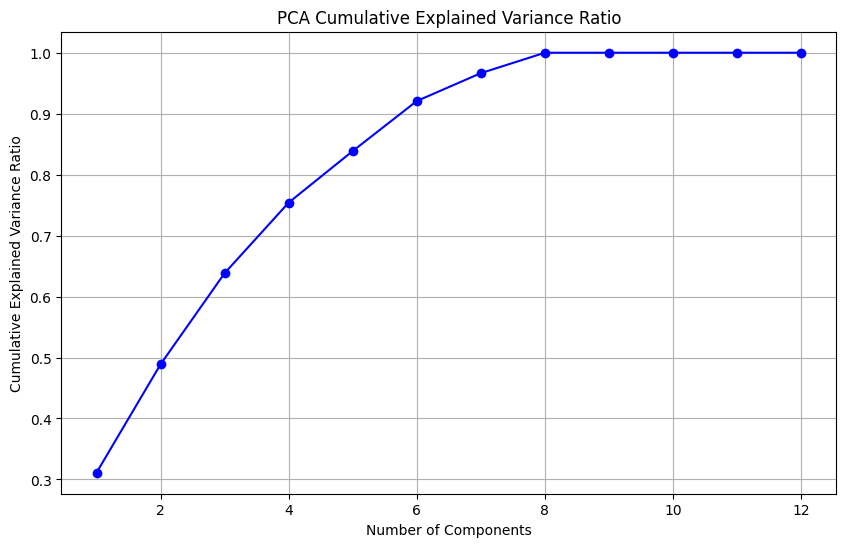

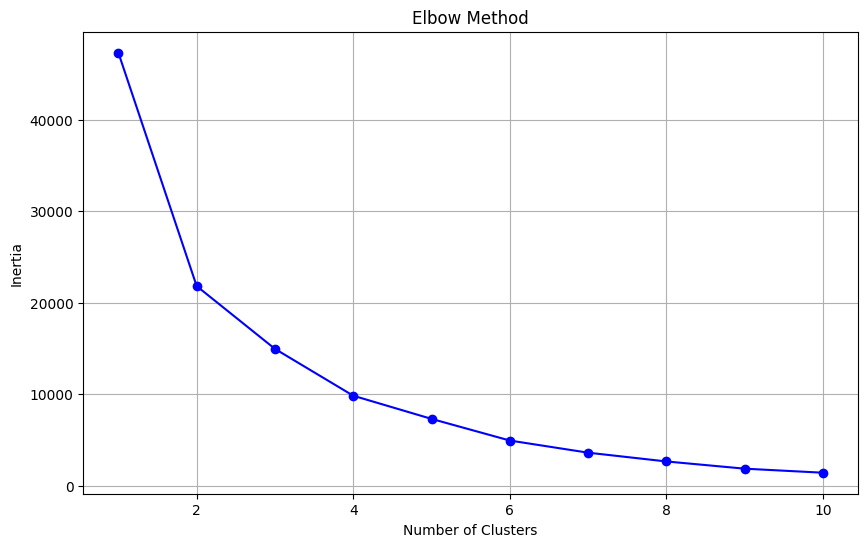

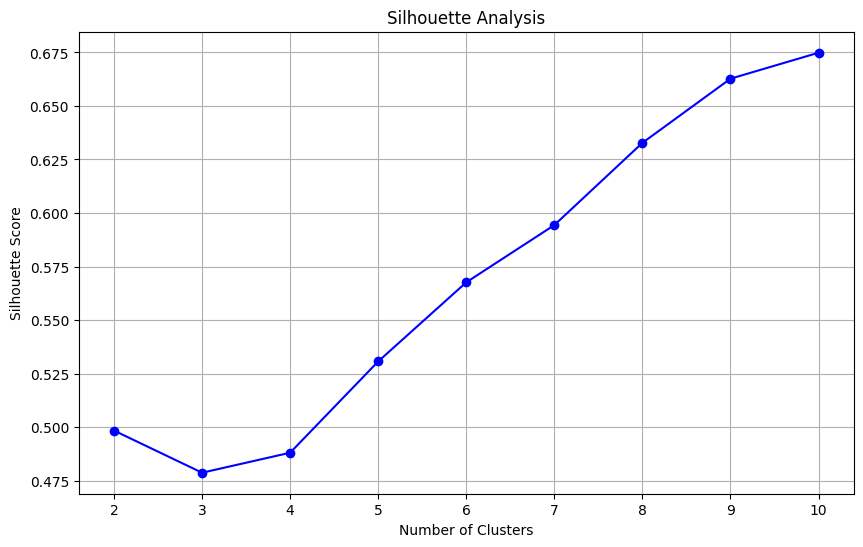

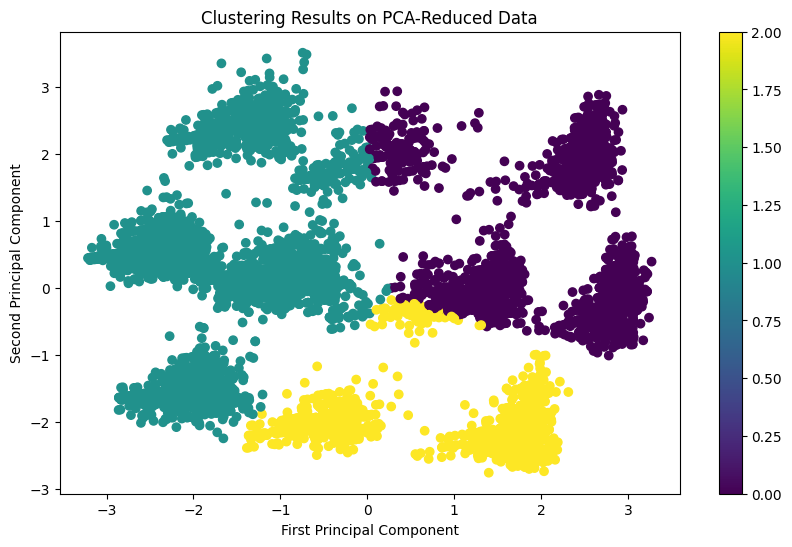


Cluster Means:
               Age  Work_Experience  Family_Size  Gender_Female  Gender_Male  \
Cluster                                                                        
0        30.297454         2.850331     3.081790       0.332176     0.667824   
1        52.455948         2.284479     2.765555       0.334993     0.665007   
2        42.106996         3.256192     2.016461       0.990398     0.009602   

         Ever_Married_No  Ever_Married_Yes  Graduated_No  Graduated_Yes  \
Cluster                                                                   
0               0.918596          0.081404      0.718750       0.281250   
1               0.000498          0.999502      0.277999       0.722001   
2               0.658436          0.341564      0.043896       0.956104   

         Spending_Score_Average  Spending_Score_High  Spending_Score_Low  
Cluster                                                                   
0                      0.000386             0.005401     

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Data scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customerSeg_encoded)

# Apply PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Check explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, 'bo-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('PCA Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Find optimal number of clusters (Elbow method)
inertias = []
n_clusters_range = range(1, 11)

for k in n_clusters_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca[:, :2])
    inertias.append(kmeans.inertia_)

# Visualize elbow curve
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.grid(True)
plt.show()

# Silhouette analysis
from sklearn.metrics import silhouette_score

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X_pca[:, :2])
    silhouette_avg = silhouette_score(X_pca[:, :2], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Visualize silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.grid(True)
plt.show()

# Clustering with optimal number of clusters
optimal_k = 3  # Adjust based on analysis
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans_optimal.fit_predict(X_pca[:, :2])

# Visualize clustering results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Clustering Results on PCA-Reduced Data')
plt.colorbar(scatter)
plt.show()

# Analyze cluster characteristics
customerSeg_encoded['Cluster'] = cluster_labels
cluster_means = customerSeg_encoded.groupby('Cluster').mean()
print("\nCluster Means:")
print(cluster_means)


### Charts Using PCA Data

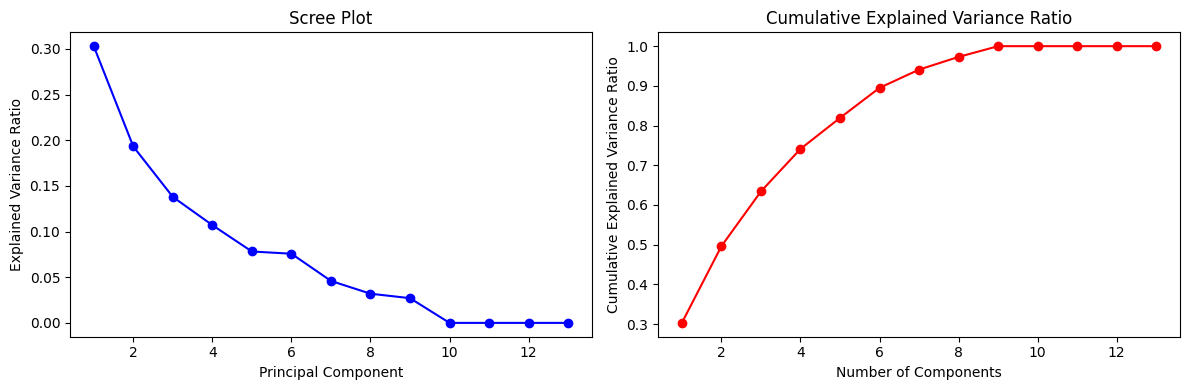

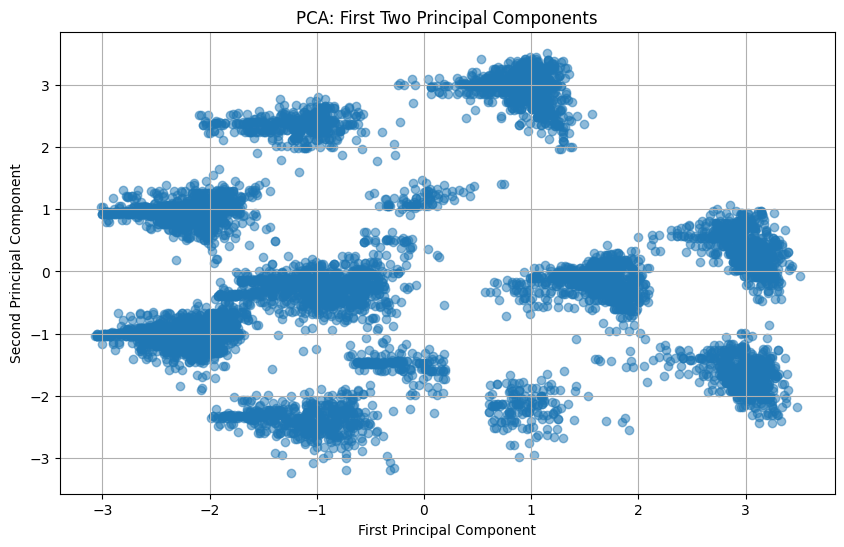

<Figure size 1200x600 with 0 Axes>

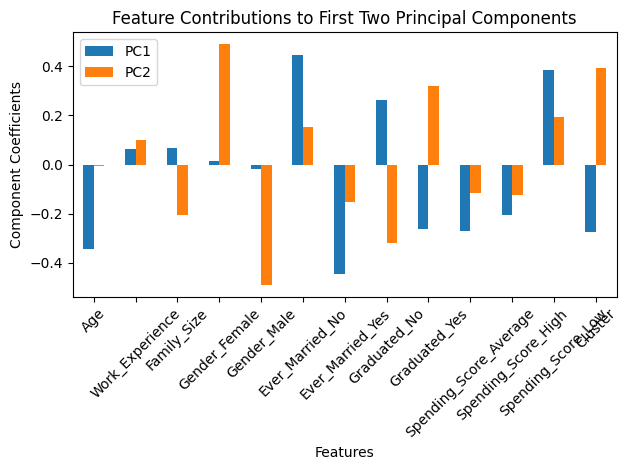

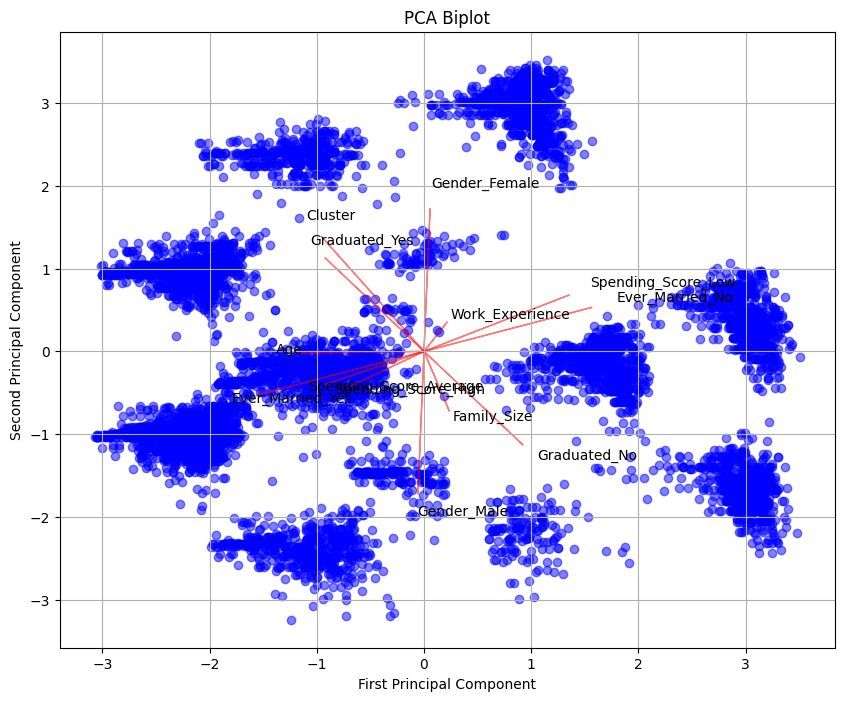


Explained Variance Ratio:
      Explained Variance Ratio  Cumulative Variance Ratio
PC1               3.029978e-01                   0.302998
PC2               1.931502e-01                   0.496148
PC3               1.379548e-01                   0.634103
PC4               1.070407e-01                   0.741144
PC5               7.817407e-02                   0.819318
PC6               7.573399e-02                   0.895052
PC7               4.594260e-02                   0.940994
PC8               3.195053e-02                   0.972945
PC9               2.705529e-02                   1.000000
PC10              1.169819e-32                   1.000000
PC11              1.030791e-32                   1.000000
PC12              3.456054e-33                   1.000000
PC13              2.574971e-33                   1.000000


'\n의미: 각 주성분의 개별 및 누적 설명력을 수치로 표현\n해석 방법:\nExplained Variance Ratio: 각 주성분이 설명하는 분산의 비율\nCumulative Variance Ratio: 누적된 설명된 분산의 비율\n높은 누적 설명력을 가진 주성분까지 선택하여 차원 축소에 활용\n'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Warning 메시지 제거
import warnings
warnings.filterwarnings('ignore')

# 기본 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'

# 데이터 스케일링
scaler = StandardScaler()
X_scaled = scaler.fit_transform(customerSeg_encoded)

# PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# 1. 설명된 분산 비율 차트
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_, 'bo-')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')

'''
Scree Plot (스크리 도표)

의미: 각 주성분이 설명하는 분산의 비율을 보여주는 그래프
해석 방법:
y축: 각 주성분이 설명하는 분산의 비율
x축: 주성분 번호
급격한 기울기 감소가 완만해지는 지점(엘보우 포인트)이 중요한 주성분의 수를 나타냄
높은 설명력을 가진 주성분일수록 그래프 초반에 높은 값을 보임
'''

# 2. 누적 설명된 분산 비율
plt.subplot(1, 2, 2)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio')
plt.tight_layout()
plt.show()

'''
누적 설명된 분산 비율 (Cumulative Explained Variance Ratio)

의미: 주성분을 누적했을 때 설명되는 총 분산의 비율
해석 방법:
y축: 누적된 설명된 분산 비율 (0~1 사이)
x축: 사용된 주성분의 수
일반적으로 0.80.9 (8090%) 이상의 설명력을 가질 때까지의 주성분 수를 선택
'''

# 3. 2D 산점도
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA: First Two Principal Components')
plt.grid(True)
plt.show()

'''
2D 산점도 (First Two Principal Components)

의미: 첫 번째와 두 번째 주성분으로 표현된 데이터의 분포
해석 방법:
x축: 첫 번째 주성분 (가장 큰 분산을 설명)
y축: 두 번째 주성분 (두 번째로 큰 분산을 설명)
데이터 포인트들의 군집이나 패턴을 확인 가능
이상치나 특이한 분포를 파악 가능
'''

# 4. Feature Contribution Plot
components = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.components_.shape[0])],
    index=customerSeg_encoded.columns
)

plt.figure(figsize=(12, 6))
components.iloc[:, [0, 1]].plot(kind='bar')
plt.title('Feature Contributions to First Two Principal Components')
plt.xlabel('Features')
plt.ylabel('Component Coefficients')
plt.legend(loc='best')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

'''
Feature Contribution Plot (변수 기여도 플롯)

의미: 각 원본 변수가 주성분에 기여하는 정도
해석 방법:
y축: 각 변수의 기여도 계수 (-1 ~ 1 사이)
x축: 원본 변수들
절대값이 클수록 해당 주성분에 더 큰 영향을 미침
양수/음수는 주성분과의 상관관계 방향을 나타냄
'''

# 5. Biplot 함수 정의
def biplot(score, coef, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coef.shape[0]

    plt.figure(figsize=(10, 8))
    plt.scatter(xs, ys, c='b', alpha=0.5)
    
    for i in range(n):
        plt.arrow(0, 0, coef[i,0]*max(xs), coef[i,1]*max(ys),
                 color='r', alpha=0.5)
        if labels is None:
            plt.text(coef[i,0]*max(xs)*1.15, coef[i,1]*max(ys)*1.15, 
                    f"Var{i+1}")
        else:
            plt.text(coef[i,0]*max(xs)*1.15, coef[i,1]*max(ys)*1.15, 
                    labels[i])
            
    plt.xlabel("First Principal Component")
    plt.ylabel("Second Principal Component")
    plt.title("PCA Biplot")
    plt.grid()
    plt.show()

# Biplot 생성
biplot(X_pca[:, 0:2], np.transpose(pca.components_[0:2, :]), customerSeg_encoded.columns)

'''
Biplot (바이플롯)

의미: 데이터 포인트와 변수의 방향을 동시에 보여주는 복합 그래프
해석 방법:
파란 점: 각 데이터 포인트
빨간 화살표: 원본 변수의 방향과 크기
화살표 길이: 해당 변수의 중요도
화살표 방향: 변수 간의 상관관계 (같은 방향일수록 양의 상관관계)
'''

# 6. 분산 설명 비율 테이블 출력
explained_variance_ratio_df = pd.DataFrame(
    {'Explained Variance Ratio': pca.explained_variance_ratio_,
     'Cumulative Variance Ratio': np.cumsum(pca.explained_variance_ratio_)},
    index=[f'PC{i+1}' for i in range(len(pca.explained_variance_ratio_))]
)
print("\nExplained Variance Ratio:")
print(explained_variance_ratio_df)

'''
의미: 각 주성분의 개별 및 누적 설명력을 수치로 표현
해석 방법:
Explained Variance Ratio: 각 주성분이 설명하는 분산의 비율
Cumulative Variance Ratio: 누적된 설명된 분산의 비율
높은 누적 설명력을 가진 주성분까지 선택하여 차원 축소에 활용
'''


### Classfication Report (F1 Score)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# 먼저 데이터에 'Segmentation' 컬럼이 있는지 확인
print("사용 가능한 컬럼:", customerSeg.columns)

# 원-핫 인코딩
encoder = OneHotEncoder(sparse=False)
encoded_array = encoder.fit_transform(customerSegOrg[['Segmentation']])  # 컬럼명이 맞는지 확인 필요

# 인코딩된 결과를 데이터프레임으로 변환
encoded_df = pd.DataFrame(
    encoded_array,
    columns=encoder.get_feature_names_out(['Segmentation'])
)

# 원본 데이터와 인코딩 결과 결합
customerSegOrg = pd.concat([customerSeg, encoded_df], axis=1)

# classification_report 사용 시 실제 레이블과 예측 레이블의 형식을 맞춰야 함
print(classification_report(y_true=kmeans_optimal.labels_, 
                          y_pred=kmeans_optimal.labels_))


사용 가능한 컬럼: Index(['Gender', 'Ever_Married', 'Age', 'Graduated', 'Work_Experience',
       'Spending_Score', 'Family_Size'],
      dtype='object')


KeyError: "None of [Index(['Segmentation'], dtype='object')] are in the [columns]"